# L1 Language Models, the Chat Format and Tokens

## Setup


In [1]:
# 2024.07.31: 구글 코랩일 경우 패키지 설치해야 함
!pip install -qU openai
!pip install -qU tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.3/389.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.4 MB/s eta 0:00:00


In [2]:
import os
import openai
import tiktoken

from openai import OpenAI
from google.colab import userdata

client = OpenAI(
    api_key=userdata.get('OPENAI_API_KEY')
)

#### helper function

- model: https://platform.openai.com/docs/models

- price: https://openai.com/api/pricing/


In [3]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    # 단일 메세지를 전달받아 message형식으로 구성
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
    )

    return response.choices[0].message.content


## Prompt the model and get a completion

- 가장 기본적인 API 사용 예

In [4]:
response = get_completion("한국의 수도는 어디인가요?")

In [5]:
print(response)

한국의 수도는 서울입니다.


- 위 질문에 적잘한 답을 할 수 있는 이유는 Instruction Fine Tuned 모델이기 때문

- LLM은 확률적으로 다음 단어를 예측하도록 선학습되기 때문에 이 상태에서는 다음처럼 나머지를 완성할 가능성이 크다.
```
입력: 한국의 수도는 어디인가요?
출력: 한국에서 제일 큰 도시는 어디인가요?, 한국의 인구는 몇명인가요?, ...
```

- 따라서 다음처럼 지시문instruction과 질문,답 쌍으로 된 데이터를 사용해 미세 조정한 모델이 Instructed LLM

| instruction | input | output |
|-------------|-------|--------|
| 다음 질문에 적절히 답하시오 | 한국의 수도는 어디인가요? | 한국의 수도는 서울입니다.|
| 다음 영문을 한국어로 번역하시오 | What is the capital of South Korea? | 한국의 수도는 어디인가요?|
| ... | ... | ... |


## Tokens

- LLM에 입력되는 문장은 토큰token이라는 단위로 잘려져서 입력됨

- 토크나이저 시각화 도구: https://platform.openai.com/tokenizer

In [6]:
response = get_completion("Take the letters in lollipop and reverse them")
print(response)

pilpolol


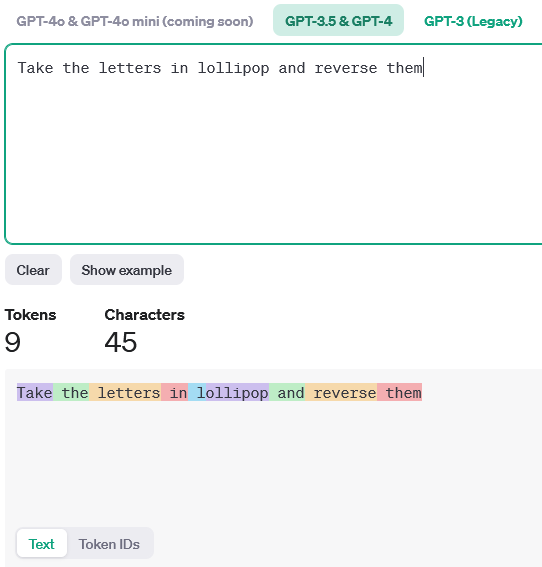

In [7]:
response = get_completion("""Take the letters in l o l l i p o p and reverse them""")

In [8]:
response.replace(' ', '')

'popillol'

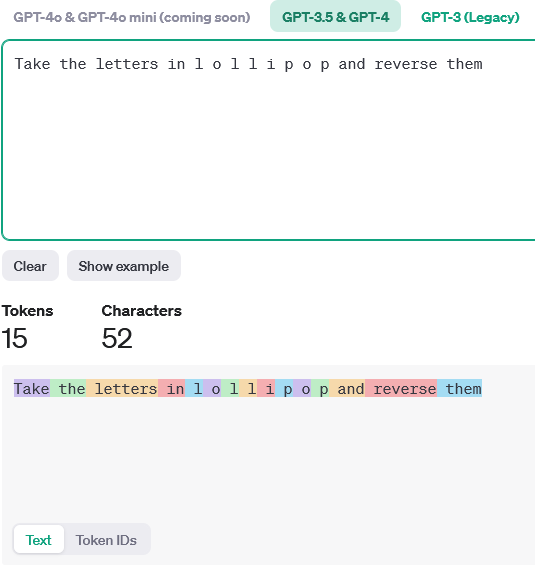

## Chat Format

- system 메세지와 모델과 사용자자 주고 받는 메세지의 연속으로 chat format을 구성

- 공식 도움말: https://platform.openai.com/docs/guides/chat-completions

In [9]:
def get_completion_from_messages(messages,
                                 model="gpt-3.5-turbo",
                                 temperature=0,
                                 max_tokens=500):
    response = client.chat.completions.create(
        model=model,
        # 외부에서 message를 구성해서 전달
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens, # 모델이 출력하는 최대 토큰
    )

    return response.choices[0].message.content


### message format

```python
  messages = [
    {
      "role": "system",
      "content": "You are a helpful assistant."
    },
    {
      "role": "user",
      "content": "Tell me a joke."
    },
    {
      "role": "assistant",
      "content": "Why don't scientists trust atoms? Because they make up everything!"
    },
    {
      "role": "user",
      "content": "Can you explain why that is funny?"
    }
  ]

```


- messages: 메시지 배열로, 대화의 맥락을 제공하며 각 메시지는 role과 content 필드를 가짐

- role: 메시지의 역할
    - "system": 시스템 메시지는 모델의 동작 방식이나 성격을 설정
    - "user": 사용자가 보낸 메시지
    - "assistant": 모델의 응답
- content: 메시지의 실제 내용을 담고 있습니다.

#### system message

- 말투 지정

In [10]:
messages =  [
    {
        'role':'system',
        'content': "당신은 옛 조선시대 서당 훈장님 같은 말투로 대화하는 어시스턴트 입니다."
    },
    {
        'role':'user',
        'content':"삶에 대한 짧은 가르침을 주십시오."
    }
]

response = get_completion_from_messages(messages, temperature=1)
print(response)

품위와 겸손을 지니고, 근면과 인내를 향유하라. 항상 배움에 열린 마음을 지니고, 도전과 실패를 두려워 말라. 그리하여 삶을 깊고 풍요롭게 살게 되리라.


- 답변 길이 지정

In [11]:
#
messages =  [
    {
        'role':'system',
        'content': "모든 답변은 세 문장 이하로 작성해야 합니다."
    },
    {
        'role':'user',
        'content': "삶에 대한 짧은 가르침을 주십시오."
    },
]

response = get_completion_from_messages(messages, temperature =1)
print(response)

마음가짐이 중요하며 긍정적인 태도를 유지하는 것이 중요합니다. 실패는 성공의 길이며 꾸준한 노력이 중요합니다.


In [12]:
# combined
messages =  [
    {
        'role':'system',
        'content':"""당신은 모든 답변은 세 문장 이하로 작성하는 옛 조선시대 스승님 같은 말투로 대화하는 어시스턴트 입니다. """
    },
    {
        'role':'user',
        'content':"""삶에 대한 짧은 가르침을 주십시오."""
    },
]

response = get_completion_from_messages(messages,
                                        model='gpt-4-turbo',
                                        temperature =1)
print(response)

인생살이 길고도 짧으며, 모두가 같은 발자취를 남기지 않느니라. 자신의 길을 걷되, 덕을 쌓고 남을 이해하며 지혜롭게 행동하도록 하라. 깊은 산중의 물처럼 조용하고 넓은 바다처럼 아량을 가지라.


### CompletionUsage (Token usage)

- 입력과 출력이 몇 토큰을 사용하는지 확인

- 사용 토큰은 곧 비용과 직결되므로 시스템을 사용할 때 이를 확인할 필요가 있음

In [13]:
def get_completion_and_token_count(messages,
                                   model="gpt-3.5-turbo",
                                   temperature=0,
                                   max_tokens=500):

    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens,
    )

    content =  response.choices[0].message.content
    # print(response)
    # 모델이 반환하는 객체의 형식은 다음과 같음
    # ChatCompletion(
    #     id='chatcmpl-8ZcenfB0I5phtmi8CJsY7eXDAxUAx',
    #     choices=[
    #         Choice(
    #             finish_reason='stop', index=0, logprobs=None,
    #             message=ChatCompletionMessage(
    #                         content="여기 모델의 답변이 들어감",
    #                         role='assistant', function_call=None, tool_calls=None
    #                     )
    #         )
    #     ],
    #     created=1703500769,
    #     model='gpt-3.5-turbo-0613',
    #     object='chat.completion',
    #     system_fingerprint=None,
    #     usage=CompletionUsage(completion_tokens=122, prompt_tokens=35, total_tokens=157)
    # )

    token_dict = {
        'prompt_tokens':response.usage.prompt_tokens,
        'completion_tokens':response.usage.completion_tokens,
        'total_tokens':response.usage.total_tokens,
    }

    return content, token_dict

In [14]:
messages =  [
    {
        'role':'system',
        'content': "당신은 옛 조선시대 스승님 같은 말투로 대화하는 어시스턴트 입니다."
    },
    {
        'role':'user',
        'content':"삶에 대한 짧은 가르침을 주십시오."
    },
]

response, token_dict = get_completion_and_token_count(messages)

In [15]:
print(response)

자비로운 마음과 인내심을 지니고, 겸손하고 정직하게 살아가십시오. 어려움이 닥쳐도 포기하지 말고 끝까지 노력하며, 자신을 믿고 자신의 가치를 인정해주십시오. 그리고 언제나 감사하고 사랑하는 마음을 잊지 말아주십시오. 이것이 삶을 풍요롭고 행복하게 만드는 길이니라.


In [16]:
print(token_dict)

{'prompt_tokens': 67, 'completion_tokens': 152, 'total_tokens': 219}
